In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import json
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt 
from PIL import Image
import csv
from tqdm import tqdm
import copy

In [2]:
network = models.resnet50(pretrained=True)

C:\Users\marku\.conda\envs\advattack\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\marku\.conda\envs\advattack\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
images = []
with open('data/mapping.txt', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        input_image = Image.open("data/images/" + row[0])
        row.append(input_image)
        images.append(row)
print(images)

[['bullet_train_1.jpg', 'bullet_train', '466', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x17AA0058B90>], ['car_wheel_1.jpg', 'car_wheel', '479', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=844x569 at 0x17AA0081D10>], ['electric_locomotive_1.jpg', 'electric_locomotive', '547', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x325 at 0x17AA00823D0>], ['guacamole_1.jpg', 'guacamole', '924', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1200x628 at 0x17AA00828D0>], ['power_drill_1.jpg', 'power_drill', '740', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=702x395 at 0x17AA0082D90>], ['red_wine_1.jpg', 'red_wine', '966', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x640 at 0x17AA00832D0>], ['rifle_1.jpg', 'rifle', '764', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=900x525 at 0x17AA00BD8D0>], ['samoyed_1.jpg', 'samoyed', '258', <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=729x486 at 0x17AA00BF310>

In [4]:
with open('data/imagenet1000_clsid_to_human.json') as json_file:
    class_idx = json.load(json_file)
    labels = {int(key): value for key, value in class_idx.items()}

<Figure size 640x480 with 0 Axes>

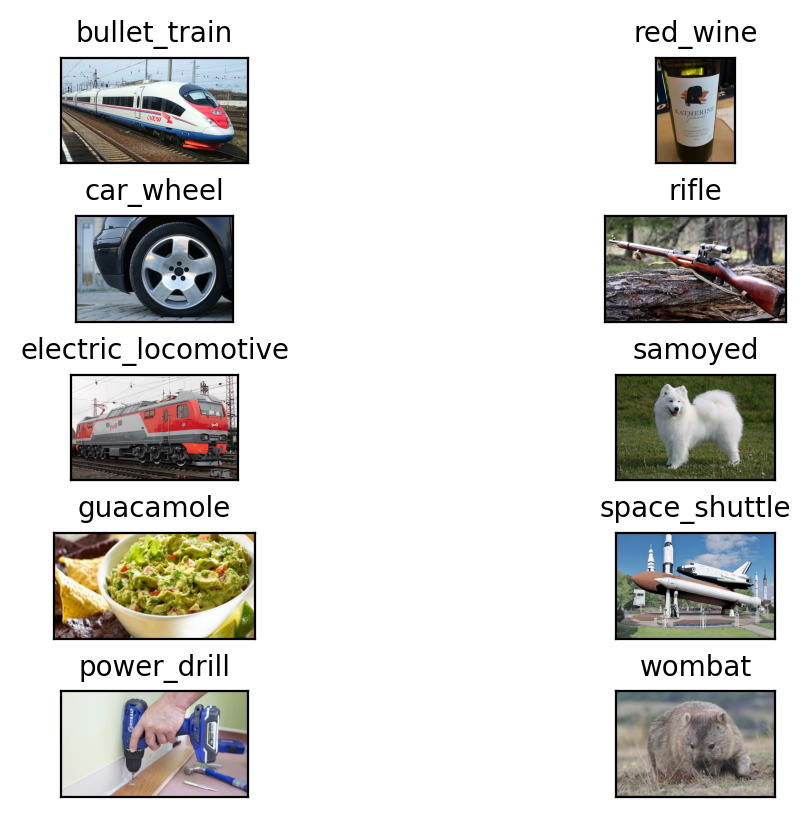

In [5]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = Image.open("data/images/" + images[i][0])
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    axarr[x, y].imshow(images[i][3])
    axarr[x, y].set_title(images[i][1], fontsize=10)
    plt.subplots_adjust(wspace=None, hspace=0.5)

In [6]:
def transform_image(image):
    centre_crop = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    input_tensor = centre_crop(image)
    input_batch = input_tensor.unsqueeze(0)
    return input_batch

def inverse_transform(image):
    inv = transforms.Compose([ 
        transforms.Normalize([ 0., 0., 0. ],[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize([ -0.485, -0.456, -0.406 ],[ 1., 1., 1. ]),])
    return inv(image)

def predict(image, network, raw_image=True):
    #use raw image, it will transform it
    #return: array of probability for each class
    input_batch = image
    if raw_image:
        input_batch = transform_image(image)
    with torch.no_grad():
        network.eval()
        prediction = network(input_batch)  
    return prediction.data.numpy()

def probabilty_of_class(image, class_index, network, raw_image=True):
    prediction = predict(image, network, raw_image)
    return prediction[0,class_index]

def get_most_probable_class(image, network, raw_image=True):
    #returns index and class name
    prediction = predict(image, network, raw_image)
    index = prediction.argmax()
    return(index, labels[index])

<Figure size 640x480 with 0 Axes>

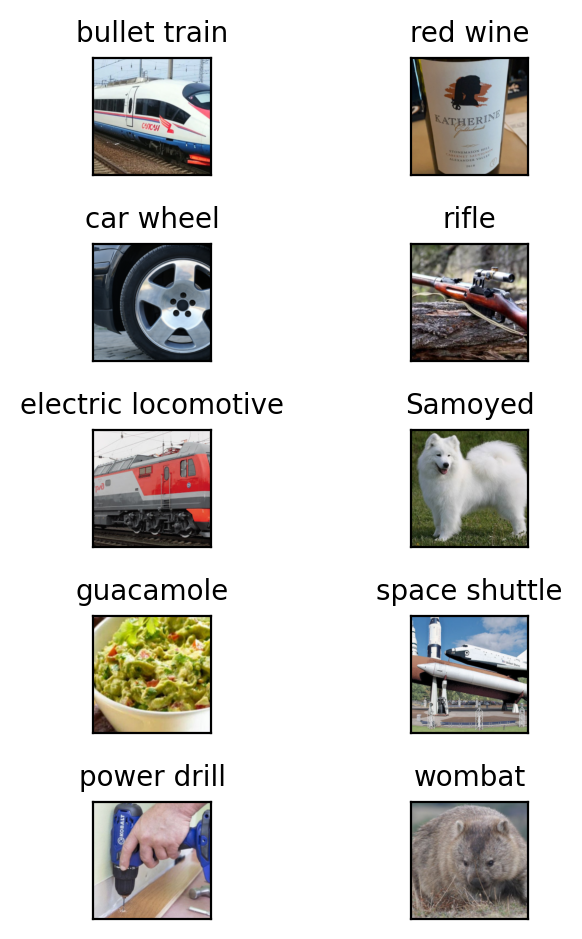

In [7]:
plt.figure()
f, axarr = plt.subplots(5,2, dpi=200) 
to_image = transforms.ToPILImage()
for i in range(10):
    y = i // 5
    x = i % 5
    input_image = transform_image(images[i][3])
    axarr[x, y].imshow(inverse_transform(input_image[0]).permute(1, 2, 0).detach().numpy() )
    axarr[x, y].axes.get_xaxis().set_visible(False)
    axarr[x, y].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(input_image, network, False)
    axarr[x, y].set_title(label.split(",")[0], fontsize=10)
    plt.tight_layout()

In [8]:
for i in images:
    i[3] = transform_image(i[3])

In [9]:

get_most_probable_class(images[0][3], network, False)

(466, 'bullet train, bullet')

In [10]:
def fast_gradient_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1):
    #return image, probability before and probabilty 
    changed_image = image
    prev_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    if iteration_count == -1:
        iteration_count = 100
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(changed_image, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        network.eval()
        image.requires_grad = True
        prediction = network_to_attack(image)

        loss = F.nll_loss(prediction, torch.tensor([correct_prediction_index]))
        network.zero_grad()
        loss.backward()

        data_grad = image.grad.data

        changed_image = changed_image + epsilon * data_grad.sign()

        changed_image = changed_image.clamp(-3, 3)
        new_prob = probabilty_of_class(changed_image, correct_prediction_index, network_to_attack, False)
    return (changed_image, prev_prob, new_prob)

In [11]:
def simba_attack(image, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1000):
    result = image
    result.requires_grad = False
    size = result.shape[1] * result.shape[2] * result.shape[3]
    perm = torch.randperm(size)
    prev_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
    start_prob = prev_prob
    if iteration_count == -1:
        iteration_count = 25000
    for i in tqdm(range(iteration_count)):
        predict_index = get_most_probable_class(result, network, False)[0]
        if predict_index != correct_prediction_index:
            break
        to_add = torch.zeros(size)
        to_add[perm[i]] = epsilon
        to_add = to_add.view(result[0].size()).clamp(-3, 3)
        result[0] += to_add
        new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
        if(new_prob < prev_prob):
            prev_prob = new_prob
        else:
            changed_image = result
            changed_image[0] -= 2*to_add
            new_prob = probabilty_of_class(result, correct_prediction_index, network_to_attack, False)
            if(new_prob < prev_prob):
                prev_prob = new_prob
            else:
                result[0] += to_add
    return (result, start_prob, prev_prob)

In [12]:
def DeepFool(input_batch, correct_prediction_index, epsilon, network_to_attack, iteration_count = 1):
    batch = input_batch.detach().clone()
    batch.requires_grad = True
    network.eval()
    prediction = network(batch)
    prediction_idx = correct_prediction_index
    new_prediction_idx = prediction_idx
    iterations = 0
    prev_prob = probabilty_of_class(input_batch, correct_prediction_index, network_to_attack, False)
    while correct_prediction_index == new_prediction_idx:
        prediction_value = prediction[0,prediction_idx]
        batch.retain_grad()
        prediction_value.backward(retain_graph=True)
        grad_preciction = batch.grad.detach().clone()
        batch.grad.data.zero_()

        w = torch.zeros_like(batch)
        f = torch.empty([1])
        ratio = 0
        n = prediction.shape[1]

        for c in tqdm(range(n)):
            if c != prediction_idx:
                prediction_c = prediction[0,c]
                batch.retain_grad()
                prediction_c.backward(retain_graph=True)
                grad_c = batch.grad.detach().clone()
                batch.grad.data.zero_()
                w_ = grad_c - grad_preciction
                f_ = prediction_c - prediction_value
                if c == 0 or (prediction_idx == 0 and c == 1):
                    f = f_
                    w = w_
                    ratio = torch.abs(f_) / torch.linalg.norm(w_)
                elif torch.abs(f_) / torch.linalg.norm(w_) < ratio:
                    f = f_
                    w = w_
                    ratio = torch.abs(f_) / torch.linalg.norm(w_)
    
        new_batch = batch.detach().clone()
        new_batch.requires_grad_(False)
        new_batch += ratio * (w > 0).type(torch.float32) * torch.abs(w)
        new_batch -= ratio * (w < 0).type(torch.float32) * torch.abs(w)
        new_batch.requires_grad_(True)

        network_to_attack.eval()
        prediction = network_to_attack(new_batch)
        new_prediction_idx = prediction.data.numpy().argmax()
        batch = new_batch
        iterations+=1
        new_prob = probabilty_of_class(batch, correct_prediction_index, network_to_attack, False)
    return (batch, prev_prob, new_prob)

**We will scip this part. It takes hours to compute as can be seen from loading bar**

In [ ]:
attacks_algorithms_name = ['fast gradient attack', 'simba', 'DeepFool']
attacks_algorithms = [fast_gradient_attack, simba_attack, DeepFool]
result = []
for i in range(len(images)):
    result.append([])
    for j in range(len(attacks_algorithms)):
        res, prev, new = attacks_algorithms[j](images[i][3], int(images[i][2]), 0.3, network, -1)
        result[i].append((attacks_algorithms_name[j], res, prev, new))

  3%|▎         | 739/25000 [01:41<1:01:09,  6.61it/s]

In [ ]:
plt.figure()
f, axarr = plt.subplots(10,len(attacks_algorithms)+1, dpi=650) 
to_image = transforms.ToPILImage()
for i in range(10):
    axarr[i, 0].imshow(inverse_transform(images[i][3][0]).permute(1, 2, 0).detach().numpy() )
    axarr[i, 0].axes.get_xaxis().set_visible(False)
    axarr[i, 0].axes.get_yaxis().set_visible(False)
    index, label = get_most_probable_class(images[i][3], network, False)
    axarr[i, 0].set_title(label.split(",")[0], fontsize=5)
    for j in range(len(attacks_algorithms)):
        axarr[i, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
        axarr[i, j+1].axes.get_xaxis().set_visible(False)
        axarr[i, j+1].axes.get_yaxis().set_visible(False)
        index, label = get_most_probable_class(result[i][j][1], network, False)
        axarr[i, j+1].set_title(label.split(",")[0], fontsize=5)
        f.subplots_adjust(wspace=-0.8, hspace = 1.2)

In [ ]:
def loss_closest(prediction,prediction_idx):
    prediction = torch.squeeze(prediction)
    s = torch.argsort(prediction,descending=True)
    loss = 0
    if prediction_idx == s[0]:
        loss = prediction[s[0]] - prediction[s[1]]
    else:
        loss = prediction[prediction_idx] - prediction[s[0]]
    return loss

def log_loss_closest(prediction,prediction_idx):
    prediction = torch.squeeze(prediction)
    s = torch.argsort(prediction,descending=True)
    loss = 0
    if prediction_idx == s[0]:
        loss = torch.log(prediction[s[0]]) - torch.log(prediction[s[1]])
    else:
        loss = torch.log(prediction[prediction_idx]) - torch.log(prediction[s[0]])
    return loss

def log_loss(prediction,prediction_idx):
    return -torch.log(prediction[0,prediction_idx])

In [ ]:

def SPSA(input_batch, network, it, N, eps, delta, alpha):
    x = copy.deepcopy(input_batch)
    prediction_idx = 0
    new_prediction_idx = 0
    print("Shape: ", input_batch.shape)
    with torch.no_grad():
        network.eval()
        prediction = network(x)
        prediction_idx = torch.argmax(prediction)
        new_prediction_idx = prediction_idx

        print(type(new_prediction_idx))
        print(type(prediction_idx))

        i = 0

        while new_prediction_idx == prediction_idx:
            print('i',i)
            i +=1
            g = torch.zeros(input_batch.shape)
            for j in range(100):
                #print('j',j)
                v = torch.randint(2, input_batch.shape)
                v[v == 0] = -1

                network.eval()
                p1 = network(x + delta * v)
                p2 = network(x - delta * v)
                
                l1 = log_loss_closest(p1, prediction_idx)
                l2 = log_loss_closest(p2, prediction_idx)
                print("Loses: ", l1, l2)
                print("Value loss shape: ", (l1 - l2).shape)
                print(v.shape)
                gj = (log_loss(p1, prediction_idx) - log_loss(p2, prediction_idx)) / (2 * delta * v)
                print(gj.shape)
                
                g += gj
            x = x - (alpha / N) * gj

            n = torch.linalg.norm(x - input_batch)
            print(n)
            if n >= eps:
                x = input_batch + (x - input_batch) * eps / torch.linalg.norm(x - input_batch)
            
            new_prediction_idx = torch.argmax(network(x))
            print(new_prediction_idx)

    return prediction_idx, new_prediction_idx, x

In [ ]:
# plt.figure()
# f, axarr = plt.subplots(5,3, dpi=400) 
# to_image = transforms.ToPILImage()
# for i in range(5, 10):
#     axarr[i-5, 0].imshow(to_image(inverse_transform(images[i][3][0])) )
#     axarr[i-5, 0].axes.get_xaxis().set_visible(False)
#     axarr[i-5, 0].axes.get_yaxis().set_visible(False)
#     index, label = get_most_probable_class(images[i][3], network, False)
#     axarr[i-5, 0].set_title(label.split(",")[0], fontsize=10)
#     for j in range(len(attacks_algorithms)):
#         axarr[i-5, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
#         axarr[i-5, j+1].axes.get_xaxis().set_visible(False)
#         axarr[i-5, j+1].axes.get_yaxis().set_visible(False)
#         index, label = get_most_probable_class(result[i][j][1], network, False)
#         axarr[i-5, j+1].set_title(label.split(",")[0], fontsize=10)
#         plt.tight_layout()

In [ ]:
# for i in range(10):
#     for j in range(len(attacks_algorithms)):
#         to_image(inverse_transform(result[i][j][1][0])).save("results/" + attacks_algorithms_name[j] + "_" + str(i)+".png", format="png")

In [ ]:
# plt.figure()
# f, axarr = plt.subplots(5,3, dpi=400) 
# to_image = transforms.ToPILImage()
# for i in range(5, 10):
#     baseImage = to_image(inverse_transform(images[i][3][0]))
#     axarr[i-5, 0].imshow( baseImage )
#     axarr[i-5, 0].axes.get_xaxis().set_visible(False)
#     axarr[i-5, 0].axes.get_yaxis().set_visible(False)
#     index, label = get_most_probable_class(images[i][3], network, False)
#     axarr[i-5, 0].set_title(label.split(",")[0], fontsize=10)
#     for j in range(1):
#         axarr[i-5, j+1].imshow(inverse_transform(result[i][j][1][0]).permute(1, 2, 0).detach().numpy() )
#         axarr[i-5, j+1].axes.get_xaxis().set_visible(False)
#         axarr[i-5, j+1].axes.get_yaxis().set_visible(False)
#         index, label = get_most_probable_class(result[i][j][1], network, False)
#         axarr[i-5, j+1].set_title(label.split(",")[0], fontsize=10)
#         axarr[i-5, j+2].imshow(0.05 * np.abs(inverse_transform(result[i][j+1][1][0]).permute(1, 2, 0).detach().numpy() - baseImage))
#         axarr[i-5, j+2].axes.get_xaxis().set_visible(False)
#         axarr[i-5, j+2].axes.get_yaxis().set_visible(False)
#         index, label = get_most_probable_class(result[i][j][1], network, False)
#         axarr[i-5, j+2].set_title(label.split(",")[0], fontsize=10)
#         plt.tight_layout()

In [ ]:
# for i in range(10):
#     for j in range(len(attacks_algorithms)):
#         baseImage = inverse_transform(images[i][3][0].detach())
#         resultImage = np.clip(inverse_transform(result[i][j][1][0].detach()), 0, 1)
#         image_to_write = np.abs(baseImage-resultImage)
#         print(image_to_write.shape)
#         image_to_write = to_image(1.0 - image_to_write / torch.amax(image_to_write))
#         image_to_write.save("results/" + attacks_algorithms_name[j] + "_diffs_" + str(i)+".png", format="png")

In [ ]:
# print(deepFoolDifference)

In [ ]:
# print(np.mean(deepFoolDifference))

In [ ]:
# print(np.std(deepFoolDifference))

In [ ]:
# statisticValue = []
# for j in range(len(attacks_algorithms)):
#     diffs = []
#     for i in range(10):
#         baseImage = inverse_transform(images[i][3][0].detach())
#         resultImage = np.clip(inverse_transform(result[i][j][1][0].detach()), 0, 1)
#         diffs.append(torch.norm(resultImage))
#     print(attacks_algorithms_name[j], ". mean: ", np.mean(diffs), "std: ", np.std(diffs))

In [ ]:
# fast_gradient_iter = [1, 3, 1, 1, 1, 1, 1, 1, 3, 1]
# fast_gradient_time = [1, 2, 1, 1, 1, 1, 1, 1, 3, 1]
# simba_iter = [1353, 11344, 14466, 8009, 1355, 335, 5709, 4271, 2161, 4419]
# simba_time = [247, 2203, 3084, 1811, 352, 90, 1583, 1157, 400, 833]
# deepfool_iter = [1001, 2002, 2002, 1001, 1001, 1001, 1001, 1001, 1001, 1001]
# deepfool_time = [168, 511, 512, 165, 178, 184, 174, 163, 166, 162]
# print("Fsgm iter: ", np.mean(fast_gradient_iter))
# print("Simba iter: ", np.mean(simba_iter))
# print("DeepFool iter: ", np.mean(deepfool_iter))
# print("Fsgm time: ", np.mean(fast_gradient_time))
# print("Simba time: ", np.mean(simba_time))
# print("Deepfool time: ", np.mean(deepfool_time))